<a href="https://colab.research.google.com/github/project-ccap/project-ccap.github.io/blob/master/2023notebooks/2023_1115onomatope_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
author: 浅川伸一
date: 2023_1115
filename: 2023_1115onomatope_generator.ipynb
---

# オノマトペ生成器

### 生成 AIR モデルによるオノマトペ生成の試み

符号化器-復号化器モデルを用いた系列生成

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2015Loung_fig1.svg" width="24%"><br/>
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center>

### 文献

* Seq2seq 翻訳モデル: Sutskever+ (2014) Sequence to Sequence Learning with Neural Networks, [arXiv:1409.3215](https://arxiv.org/abs/1409.3215)
* 注意つき符号化器‐復号化器モデル: Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, [arXiv:1409.0473](https://arxiv.org/abs/1409.0473)
* もう一つの注意つき符号化器‐復号化器モデル Luong+ (2015) Effective Approaches to Attention-based Neural Machine Translation, [arXiv:1508.04025](https://arxiv.org/abs/1508.04025)


# 0 準備

## 0.1 必要なライブラリの輸入

## 0.2 小野ら ｢日本語オノマトペ辞典 4500｣ のデータ

In [2]:
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'

import sys
import os
import numpy as np
from tqdm.notebook import tqdm
import time
import datetime
import matplotlib.pyplot as plt

# 2021/Jan 近藤先生からいただいたオノマトペ辞典のデータの読み込み

#'日本語オノマトペ辞典4500より.xls' は著作権の問題があり，公にできません。
# そのため Google Colab での解法，ローカルファイルよりアップロードしてください
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

import os
HOME = os.environ['HOME']

try:
    import jaconv
except ImportError:
    !pip install jaconv

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

if isColab:
    from google.colab import files
    uploaded = files.upload()  # ここで `日本語オノマトペ辞典4500より.xls` を指定してアップロードする
    data_dir = '.'
else:
    data_dir = os.path.join(HOME,'study/2021ccap/notebooks')

import pandas as pd

onomatopea_excel = '2021-0325日本語オノマトペ辞典4500より.xls'
onmtp2761 = pd.read_excel(os.path.join(data_dir, onomatopea_excel), sheet_name='2761語')

#すべてカタカナ表記にしてデータとして利用する場合
#`日本語オノマトペ辞典4500` はすべてひらがな表記だが，一般にオノマトペはカタカナ表記されることが多いはず
#onomatopea = list(sorted(set([jaconv.hira2kata(o) for o in onmtp2761['オノマトペ']])))

# Mac と Windows の表記の相違を吸収
onomatopea_vocab = list(sorted(set([jaconv.normalize(o) for o in onmtp2761['オノマトペ']])))
print(f'データファイル名: {os.path.join(data_dir, onomatopea_excel)}\n',
      f'オノマトペ単語総数: len(onomatopea_vocab):{len(onomatopea_vocab)}')

# 近藤先生との議論から音韻情報の代替案として，ローマ字表記を採用することとした。
# このとき，訓令式の表記にすることとした。ヘボン式，パスポート式ではないことに注意
try:
    from kunrei import kunrei
except ImportError:
    !wget https://shinasakawa.github.io/2023notebooks/kunrei.py -O kunrei.py
    from kunrei import kunrei

Saving 2021-0325日本語オノマトペ辞典4500より.xls to 2021-0325日本語オノマトペ辞典4500より.xls
データファイル名: ./2021-0325日本語オノマトペ辞典4500より.xls
 オノマトペ単語総数: len(onomatopea_vocab):1741
--2023-11-15 02:45:53--  https://shinasakawa.github.io/2023notebooks/kunrei.py
Resolving shinasakawa.github.io (shinasakawa.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to shinasakawa.github.io (shinasakawa.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21158 (21K) [application/octet-stream]
Saving to: ‘kunrei.py’

kunrei.py           100%[===================>]  20.66K  --.-KB/s    in 0.006s  

2023-11-15 02:45:53 (3.22 MB/s) - ‘kunrei.py’ saved [21158/21158]



## 0.3 オノマトペをローマ字変換して，音韻情報として用いる

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=9d05ac7d21698300df3ff7a523924ee73b8147353ed9e27e5dfdac0e153c5275
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


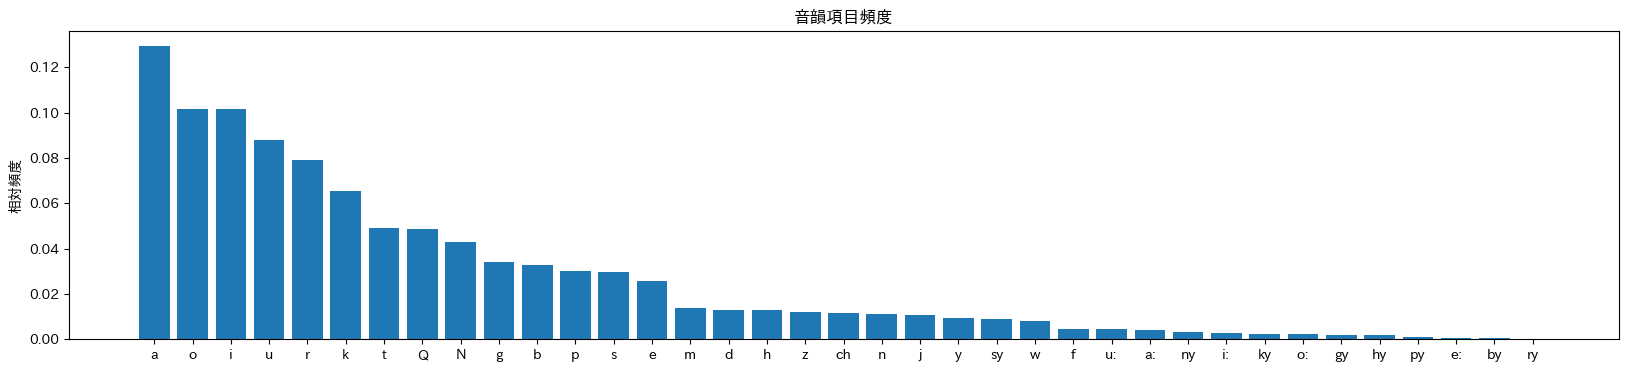

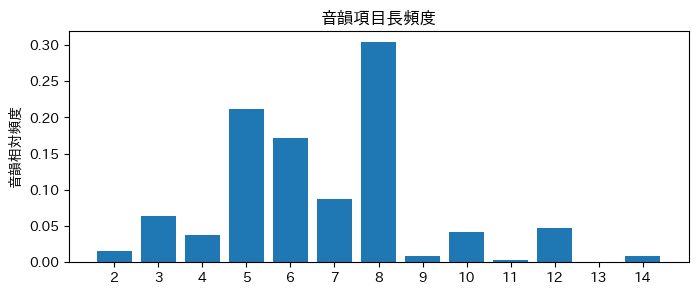

['N', 'Q', 'a', 'a:', 'b', 'by', 'ch', 'd', 'e', 'e:', 'f', 'g', 'gy', 'h', 'hy', 'i', 'i:', 'j', 'k', 'ky', 'm', 'n', 'ny', 'o', 'o:', 'p', 'py', 'r', 'ry', 's', 'sy', 't', 'u', 'u:', 'w', 'y', 'z'] 37


In [5]:
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib

try:
    from RAM import draw_word_char_histgram
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    from RAM import draw_word_char_histgram

d = {w:kunrei(w).split(' ') for w in sorted(set([jaconv.hira2kata(w) for w in onomatopea_vocab]))}
dd = {}
for i, (k, v) in enumerate(d.items()):
    dd[i] = {'wrd':k, 'val':v}
draw_word_char_histgram(_dict=dd, key='val', title='音韻', figsize2=(8,3))

phoneme = []
for p in d.values():
    for _p in p:
        if not _p in phoneme:
            phoneme.append(_p)
phoneme = sorted(set(phoneme))
print(phoneme, len(phoneme))


## 0.4 オノマトペに対応する意味表現を word2vec データから抽出して用いる

In [6]:
%%time
# word2vec のため gensim を使う
import requests
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
HOME = os.environ['HOME']

w2v_2017 = {
    'cbow200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz',
    'sgns200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz',
    'cbow300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid300_win20_neg20_sgns.bin.gz',
    'sgns300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
}

w2v_2021 = {
    'cbow128': { 'id': '1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb',
                'outfile': '2021_05jawiki_hid128_win10_neg10_cbow.bin.gz'},
    'sgns128': { 'id': '1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M',
                'outfile': '2021_05jawiki_hid128_win10_neg10_sgns.bin.gz'},
    'cbow200': { 'id': '1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s',
                'outfile': '2021_05jawiki_hid200_win20_neg20_sgns.bin.gz'}
}

is2017=True

if isColab:
    from google_drive_downloader import GoogleDriveDownloader as gdd

    if is2017:
        response = requests.get(w2v_2017['cbow200'])
        fname = w2v_2017['cbow200'].split('/')[-1]
        with open(fname, 'wb') as f:
            f.write(response.content)
    else:
        #訓練済 word2vec ファイルの取得
        (f_id, outfile) = w2v_2021['sgns128']['id'], w2v_2021['sgns128']['outfile']
        gdd.download_file_from_google_drive(file_id=f_id,
                                            dest_path=outfile,
                                            unzip=False,
                                            showsize=True)

if is2017:
    w2v_base = os.path.join(HOME, 'study/2016wikipedia/') if not isColab else '.'
    w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
    w2v_file = os.path.join(w2v_base, w2v_file)
else:
    w2v_base = os.path.join(HOME, 'study/2019attardi_wikiextractor.git/wiki_texts/AA') if isMac else '.'
    w2v_file = '2021_05jawiki_hid128_win10_neg10_sgns.bin'

w2v = KeyedVectors.load_word2vec_format(
    w2v_file,
    encoding='utf-8',
    unicode_errors='replace',
    binary=True)

CPU times: user 43.3 s, sys: 13.5 s, total: 56.8 s
Wall time: 1min 38s


In [7]:
# オノマトペデータから word2vec の埋め込みベクトル行列を得る
import numpy as np

_words = []
for o in d.keys():
    if o in w2v:
        _words.append(o)
_words = (sorted(set(_words)))
print(f'len(_words):{len(_words)}') # 936

# gensim() の `vectors_for_all()` 関数を持ちて，望む語彙で構成される word2vec 単語埋め込みモデルを作成
w2v_onomatope = w2v.vectors_for_all(_words)

# NaN データが入っている可能性がるので変換
w2v_onomatope.vectors = np.nan_to_num(w2v_onomatope.vectors)
print(f'w2v_onomatope.vectors.shape:{w2v_onomatope.vectors.shape}')
words = w2v_onomatope.index_to_key
print(len(words))

len(_words):936
w2v_onomatope.vectors.shape:(936, 200)
936


## 0.5 データチェック

In [8]:
Wrd = jaconv.hira2kata(input('オノマトペを一つを入力してください:'))
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_onomatope:
        Idx = w2v_onomatope.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v.get_index({Wrd}):{colored(w2v_onomatope.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} というオノマトペはありません。','red', attrs=['bold']))
    Wrd = jaconv.hira2kata(input('オノマトペを一つを入力してください (終了するには改行のみを入力):'))

オノマトペを一つを入力してください:安価
安価 というオノマトペはありません。
オノマトペを一つを入力してください (終了するには改行のみを入力):アンカ
アンカ というオノマトペはありません。
オノマトペを一つを入力してください (終了するには改行のみを入力):マシマシ
マシマシ というオノマトペはありません。
オノマトペを一つを入力してください (終了するには改行のみを入力):びしょびしょ
入力単語 Wrd:ビショビショ, 対応する単語番号 Idx:652, w2v.get_index(ビショビショ):652
オノマトペを一つを入力してください (終了するには改行のみを入力):キンキン
入力単語 Wrd:キンキン, 対応する単語番号 Idx:149, w2v.get_index(キンキン):149
オノマトペを一つを入力してください (終了するには改行のみを入力):リンリン
リンリン というオノマトペはありません。
オノマトペを一つを入力してください (終了するには改行のみを入力):キョンキョン
キョンキョン というオノマトペはありません。
オノマトペを一つを入力してください (終了するには改行のみを入力):キョロキョロ
入力単語 Wrd:キョロキョロ, 対応する単語番号 Idx:141, w2v.get_index(キョロキョロ):141
オノマトペを一つを入力してください (終了するには改行のみを入力):


# 1 オノマトペ復唱モデル

## 1.1 データセットの定義

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gensim

def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

class onomatope_Dataset(Dataset):
    def __init__(self,
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_onomatope,
                 phoneme:list=phoneme):
        super().__init__()
        self.ds_name = 'onomatope_dataset'
        self.w2v = w2v
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + phoneme

        # gensim の KeyedVectors を利用して単語リストとする
        self.words = w2v.index_to_key
        self.W = w2v.vectors

        wrd2phn = {}
        for wrd in self.words:
            phon = kunrei(wrd).split()
            wrd2phn[wrd] = phon
        self.wrd2phon = wrd2phn

    def __len__(self):
        return len(words) # 936

    def __getitem__(self, idx:int):
        wrd = self.words[idx]
        phon = self.wrd2phon[wrd]
        phon_ids = [self.phoneme.index(p) for p in phon]
        phon_ids = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]

        inp = torch.LongTensor(phon_ids)
        tch = torch.LongTensor(phon_ids)

        #sem_ = self.w2v[wrd]
        return inp, tch

    def getitem(self, idx:int):
        wrd = self.words[idx]
        phon = self.wrd2phon[wrd]
        phon_ids = [self.phoneme.index(p) for p in phon]
        phon_ids = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        return wrd, phon, phon_ids

    def target_ids2target(self, ids:list):
        return self.phon_ids2phon(ids)

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def idx2wrd(self, idx:int) ->str:
        return self.words[idx]

ono_ds = onomatope_Dataset()
print(ono_ds.__len__())
print(ono_ds.__getitem__(935))

print(ono_ds.phon_ids2phon([1,38,7,4,2]))
print(ono_ds.idx2wrd(935))

936
(tensor([ 1, 38,  7,  4,  2]), tensor([ 1, 38,  7,  4,  2]))
['<SOW>', 'w', 'a:', 'N', '<EOW>']
ワーン


## 1.2 ハイパーパラメータの定義

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# Hyper parameters
n_hid = 32
n_layers = 1
bidirectional=False
batch_size = 128

## 1.3 符号化器‐復号化器モデルの定義

In [11]:
class Seq2Seq_wAtt(nn.Module):
    """ 注意つき符号化器‐復号化器モデル
    Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, arXiv:1409.0473
    """
    def __init__(self,
                 enc_vocab_size:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # Encoder 側の入力トークン id を多次元ベクトルに変換
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Decoder 側の入力トークン id を多次元ベクトルに変換
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Encoder LSTM 本体
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # Decoder LSTM 本体
        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 文脈ベクトルと出力ベクトルの合成を合成する層
        bi_fact = 2 if bidirectional else 1
        self.combine_layer = nn.Linear(bi_fact * 2 * n_hid, n_hid)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は (バッチサイズ，ソースの単語数，中間層の次元数)
        # ソース側 (enc_out) の各単語とターゲット側 (dec_out) の各単語との類似度を測定するため
        # 両テンソルの内積をとるため ソース側 (enc_out) の軸を入れ替え
        enc_outP = enc_out.permute(0,2,1)

        # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
        sim = torch.bmm(dec_out, enc_outP)

        # sim の各次元のサイズを記録
        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを行うため形状を変更
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # simP のソフトマックスを用いて注意の重み alpha を算出
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
        c_t = torch.bmm(alpha, enc_out)

        # torch.cat だから c_t と dec_out とで合成
        dec_out_ = torch.cat([c_t, dec_out], dim=2)
        dec_out_ = self.combine_layer(dec_out_)

        return self.out_layer(dec_out_)


# 以下確認作業
ds = ono_ds
p2p = Seq2Seq_wAtt(enc_vocab_size=len(ds.phoneme),
                   dec_vocab_size=len(ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)
print(p2p.eval())

Seq2Seq_wAtt(
  (encoder_emb): Embedding(41, 32, padding_idx=0)
  (decoder_emb): Embedding(41, 32, padding_idx=0)
  (encoder): LSTM(32, 32, batch_first=True)
  (decoder): LSTM(32, 32, batch_first=True)
  (combine_layer): Linear(in_features=64, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=41, bias=True)
)


# 1.4 訓練関数の定義

epoch: 1 batch: 8 loss:1.13896
epoch: 2 batch: 8 loss:1.10619
epoch: 3 batch: 8 loss:1.05194
epoch: 4 batch: 8 loss:0.95868
epoch: 5 batch: 8 loss:0.85195
epoch: 6 batch: 8 loss:0.76446
epoch: 7 batch: 8 loss:0.67649
epoch: 8 batch: 8 loss:0.64557
epoch: 9 batch: 8 loss:0.57184
epoch:10 batch: 8 loss:0.51406
epoch:11 batch: 8 loss:0.46420
epoch:12 batch: 8 loss:0.41576
epoch:13 batch: 8 loss:0.37683
epoch:14 batch: 8 loss:0.35133
epoch:15 batch: 8 loss:0.28895
epoch:16 batch: 8 loss:0.26126
epoch:17 batch: 8 loss:0.24195
epoch:18 batch: 8 loss:0.19175
epoch:19 batch: 8 loss:0.15128
epoch:20 batch: 8 loss:0.17765
epoch:21 batch: 8 loss:0.13056
epoch:22 batch: 8 loss:0.17758
epoch:23 batch: 8 loss:0.13381
epoch:24 batch: 8 loss:0.09493
epoch:25 batch: 8 loss:0.05823
epoch:26 batch: 8 loss:0.06847
epoch:27 batch: 8 loss:0.06894
epoch:28 batch: 8 loss:0.07584
epoch:29 batch: 8 loss:0.06395
epoch:30 batch: 8 loss:0.06120
epoch:31 batch: 8 loss:0.03288
epoch:32 batch: 8 loss:0.03829
epoch:33

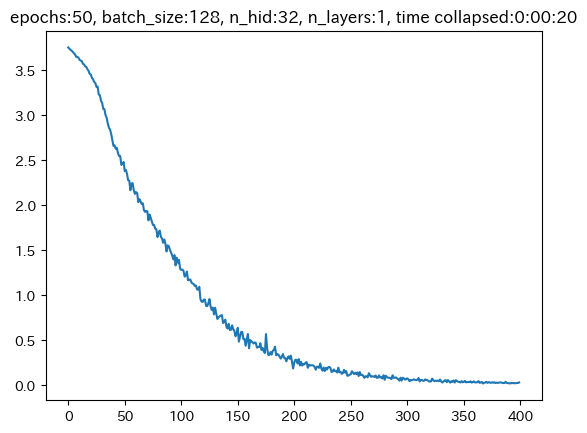

In [12]:
def fit_seq2seq(
    model:torch.nn.modules.module.Module=p2p,
    epochs:int=10,
    ds:Dataset=ono_ds,
    batch_size=batch_size,
    collate_fn=_collate_fn,
    optimizer:torch.optim=None,
    criterion:torch.nn.modules.loss=nn.CrossEntropyLoss(ignore_index=-1),
    interval:int=None,
    isPrint:bool=False,
    losses:list=None,
    isDraw:bool=True,):
    """ Seq2seq の訓練に用いる関数"""

    start_time = time.time()   # 開始時刻の保存

    dataloader = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn)


    if losses == None:
        losses = []

    model.train()

    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    if interval == None:
        interval = int(ds.__len__()/batch_size) >> 2

    for epoch in range(epochs):
        i = 0
        for _inp, _tch in dataloader:
            enc_inp = pad_sequence(_inp, batch_first=True).to(device)
            dec_inp = pad_sequence(_tch, batch_first=True).to(device)
            tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
            out = model(enc_inp, dec_inp)
            loss = criterion(out[0], tch[0])
            for h in range(1,len(tch)):
                loss += criterion(out[h], tch[h])
            losses.append(loss.item()/len(_inp))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1
            if (i % interval) == 0:
                print(f'epoch:{epoch+1:2d}',
                      f'batch:{i:2d}',
                      f'loss:{loss.item()/batch_size:.5f}')

    end_time = time.time()
    total_time = end_time - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))

    if isDraw:
        plt.plot(losses)
        plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
        plt.show()

    return {'Training time':total_time_str,
            'losses': losses,
            'optimizer': optimizer,
            'time': total_time
           }

results = fit_seq2seq(epochs=50, model=p2p, ds=ono_ds, interval=8) # 音読モデル

# 1.5 評価関数の定義

In [13]:
def eval_seq2seq(
    model:torch.nn.modules.module.Module=p2p,
    ds:Dataset=ono_ds,
    isPrint:bool=False,
    errors:list=None):

    model.eval()
    if errors == None:
        errors=[]

    for N in tqdm(range(ds.__len__())):
        x, y = ds.__getitem__(N)
        enc_inp, dec_inp = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        grand_truth = y.detach().numpy()[1:-1]
        y_hat = model(enc_inp, dec_inp).to('cpu')
        y_hat = np.argmax(y_hat.squeeze(0).detach().numpy(), axis=1)[1:-1]

        if len(y_hat) == len(grand_truth):
            n_correct = np.array((y_hat == grand_truth).sum())
            isOK = n_correct == len(grand_truth)
        else:
            isOK = False

        if not isOK:
            wrd = ds.getitem(N)[0]
            _out = ds.target_ids2target(y_hat)
            errors.append((N, wrd, _out,y_hat))
            if isPrint:
                color = 'grey' if isOK else 'red'
                wrd = ds.getitem(N)[0]
                print(colored(f'{N:05d}', color),
                      colored(wrd, color='grey'), # , attrs=["bold"]),
                      colored(y_hat,color,attrs=["bold"]),
                      colored(ds.target_ids2target(y_hat), color, attrs=["bold"]),
                      f'<-{ds.target_ids2target(grand_truth)}')

    cr = len(errors) / N
    return {'エラー':errors,
            '正解率': (1.-cr) * 100}

In [14]:
#fit_seq2seq(epochs=10, model=p2p, ds=ono_ds, interval=8)
eval_seq2seq(model=p2p, ds=ono_ds)

  0%|          | 0/936 [00:00<?, ?it/s]

{'エラー': [(9, 'アーン', ['i', 'N'], array([19,  4])),
  (81, 'カーッ', ['k', 'i', 'Q'], array([22, 19,  5])),
  (133, 'キャー', ['ky', 'h'], array([23, 17])),
  (134, 'キャーキャー', ['ky', 'ky', 'ky', 'ky'], array([23, 23, 23, 23])),
  (163, 'ギャー', ['gy', 'h'], array([16, 17])),
  (306, 'ザーザー', ['z', 'h', 'z', 'h'], array([40, 17, 40, 17])),
  (426, 'ター', ['t', 'i'], array([35, 19])),
  (433, 'ダー', ['d', 'h'], array([11, 17])),
  (452, 'チュッ', ['ch', 'ch', 'Q'], array([10, 10,  5])),
  (596, 'バーン', ['b', 'i', 'N'], array([ 8, 19,  4])),
  (624, 'パー', ['p', 'h'], array([29, 17])),
  (661, 'ビュッ', ['py', 'u', 'Q'], array([30, 36,  5])),
  (664, 'ビュー', ['py', 'u:'], array([30, 37])),
  (665, 'ビュービュー', ['py', 'u:', 'by', 'u:'], array([30, 37,  9, 37])),
  (933, 'ワーッ', ['w', 'i', 'Q'], array([38, 19,  5])),
  (935, 'ワーン', ['w', 't', 'N'], array([38, 35,  4]))],
 '正解率': 98.28877005347594}

# 1.6 結果の保存

In [15]:
sd = p2p.state_dict()
torch.save(sd, '2023_1115onomatope_p2p.pt')

p2p_ = Seq2Seq_wAtt(enc_vocab_size=len(ds.phoneme),
                    dec_vocab_size=len(ds.phoneme),
                    n_layers=n_layers,
                    bidirectional=bidirectional,
                    n_hid=n_hid).to(device)
p2p_.load_state_dict(sd)
print(p2p_.eval())
eval_seq2seq(model=p2p_, ds=ono_ds)
#for k, v in sd.items():
#    print(k)

Seq2Seq_wAtt(
  (encoder_emb): Embedding(41, 32, padding_idx=0)
  (decoder_emb): Embedding(41, 32, padding_idx=0)
  (encoder): LSTM(32, 32, batch_first=True)
  (decoder): LSTM(32, 32, batch_first=True)
  (combine_layer): Linear(in_features=64, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=41, bias=True)
)


  0%|          | 0/936 [00:00<?, ?it/s]

{'エラー': [(9, 'アーン', ['i', 'N'], array([19,  4])),
  (81, 'カーッ', ['k', 'i', 'Q'], array([22, 19,  5])),
  (133, 'キャー', ['ky', 'h'], array([23, 17])),
  (134, 'キャーキャー', ['ky', 'ky', 'ky', 'ky'], array([23, 23, 23, 23])),
  (163, 'ギャー', ['gy', 'h'], array([16, 17])),
  (306, 'ザーザー', ['z', 'h', 'z', 'h'], array([40, 17, 40, 17])),
  (426, 'ター', ['t', 'i'], array([35, 19])),
  (433, 'ダー', ['d', 'h'], array([11, 17])),
  (452, 'チュッ', ['ch', 'ch', 'Q'], array([10, 10,  5])),
  (596, 'バーン', ['b', 'i', 'N'], array([ 8, 19,  4])),
  (624, 'パー', ['p', 'h'], array([29, 17])),
  (661, 'ビュッ', ['py', 'u', 'Q'], array([30, 36,  5])),
  (664, 'ビュー', ['py', 'u:'], array([30, 37])),
  (665, 'ビュービュー', ['py', 'u:', 'by', 'u:'], array([30, 37,  9, 37])),
  (933, 'ワーッ', ['w', 'i', 'Q'], array([38, 19,  5])),
  (935, 'ワーン', ['w', 't', 'N'], array([38, 35,  4]))],
 '正解率': 98.28877005347594}

# 1.7 音韻符号化器から音韻埋め込みベクトルを取り出す

In [16]:
phone_emb_vec = []
p2p_.eval()
for N in range(ono_ds.__len__()):
    inp, tch = ono_ds.__getitem__(N)
    enc_emb = p2p_.encoder_emb(inp)
    enc_out, (hnx, cnx) = p2p_.encoder(enc_emb)
    phone_emb_vec.append(hnx.detach().squeeze(0).numpy())
phone_emb = np.array(phone_emb_vec)
print(phone_emb.shape)

(936, 32)


# 1.8 tSNE を用いた音韻埋め込みベクトルの可視化

In [18]:
# tSNE の実行
import numpy as np
try:
    from ccap import tsne
except ImportError:
    !git clone https://github.com/ShinAsakawa/ccap.git
    from ccap import tsne

np.random.seed(42)
X0 = tsne.tsne(phone_emb)

Cloning into 'ccap'...
remote: Enumerating objects: 853, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 853 (delta 146), reused 253 (delta 138), pack-reused 580
Receiving objects: 100% (853/853), 38.43 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  936 ...
Computing P-values for point  500  of  936 ...
Mean value of sigma:  0.4776060672494736
Iteration  250 : error is  0.5600555071481897
Iteration  500 : error is  0.5361186645079581
Iteration  750 : error is  0.5326968718972724
Iteration  1000 : error is  0.5315659169789583


Text(0.5, 1.0, '音韻の布置')

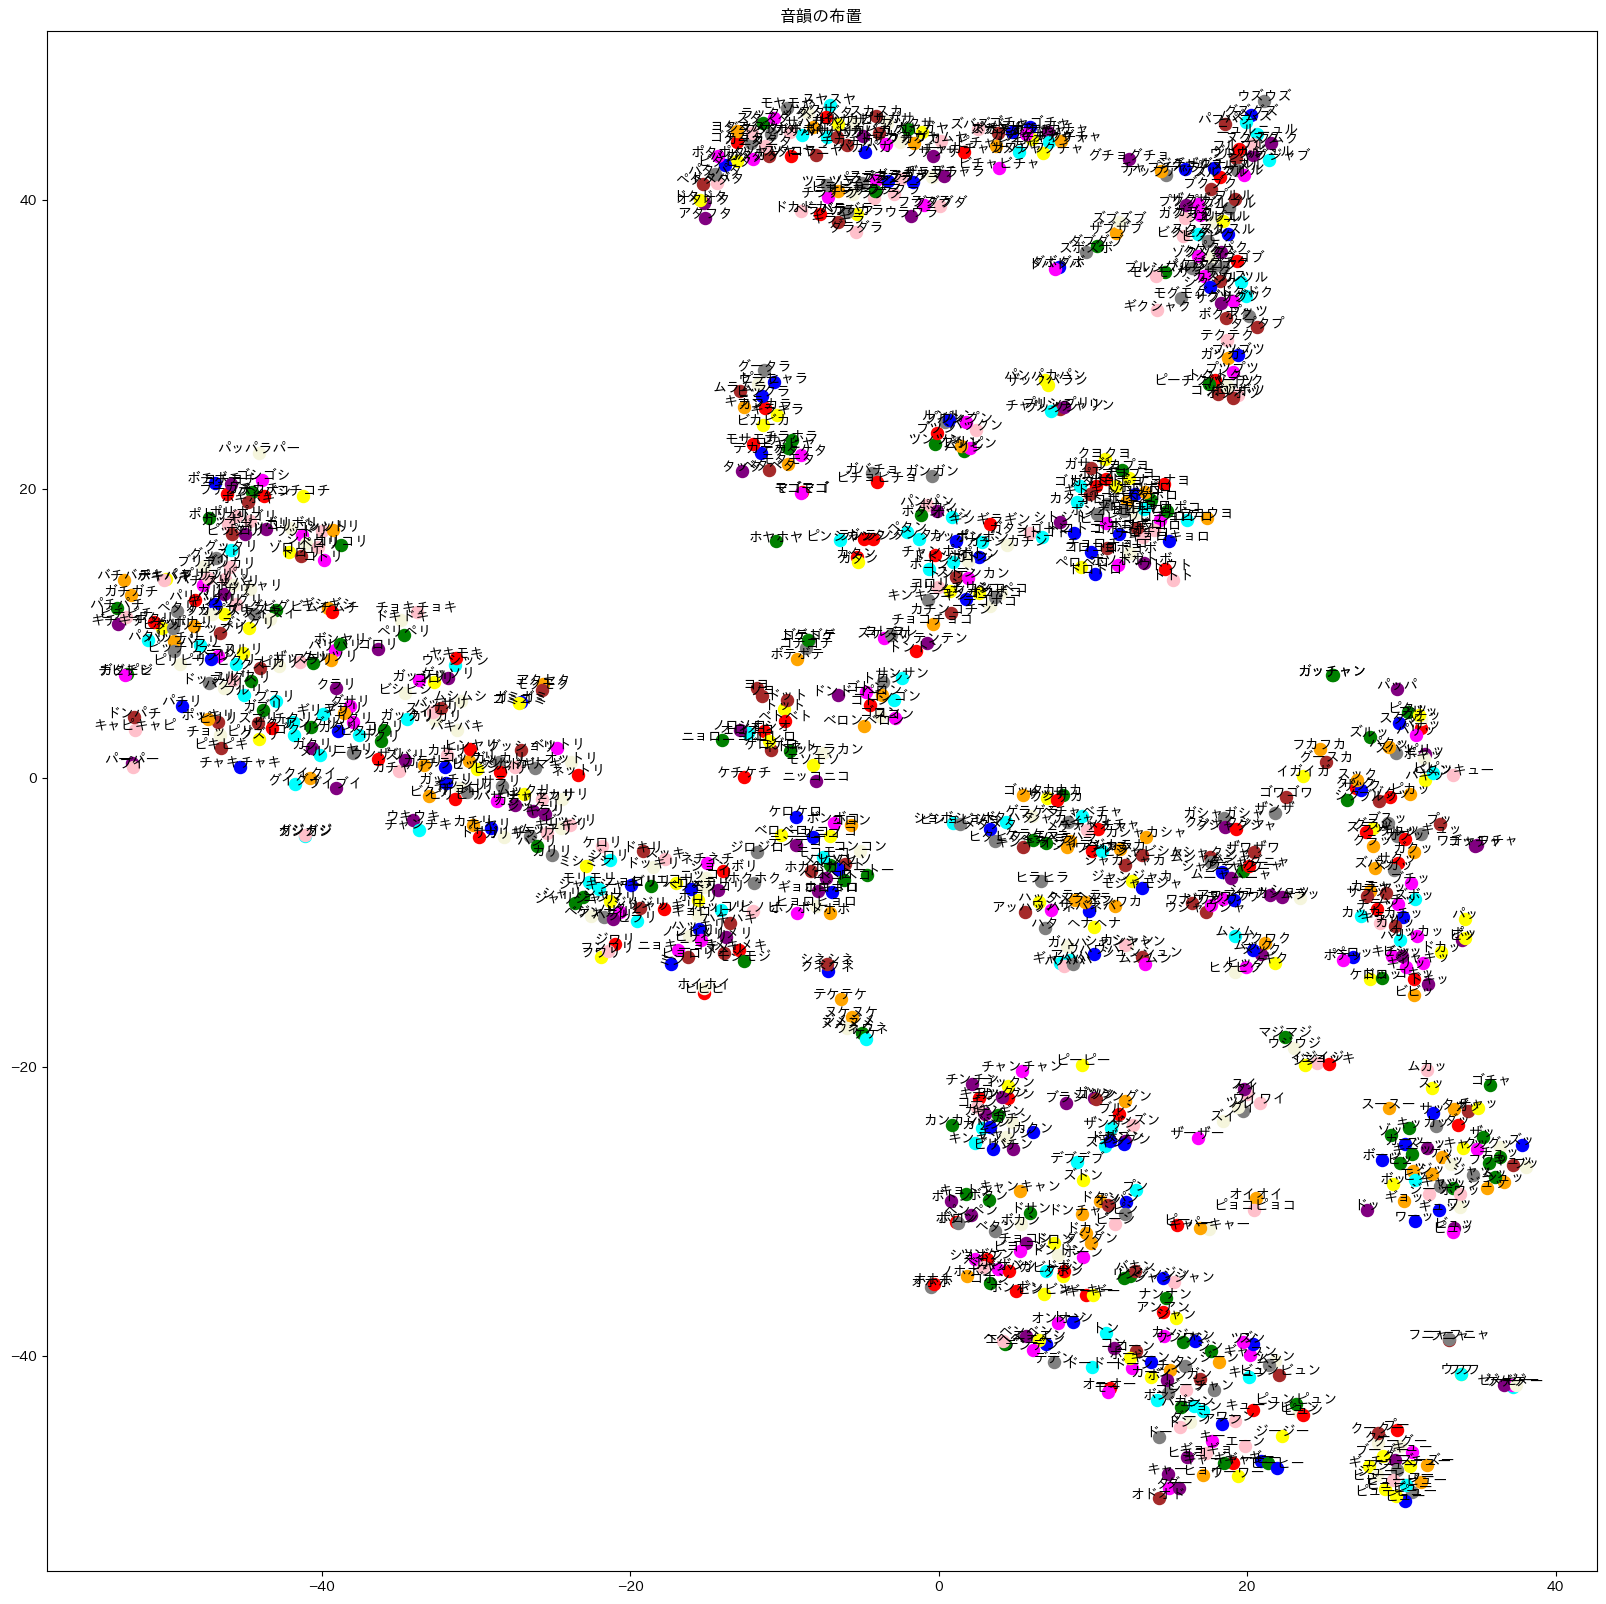

In [ ]:
import matplotlib.pyplot as plt

colors = np.array(["orange", "purple", "beige", "brown",
                   "gray", "cyan", "magenta", "red",
                   "green", "blue", "yellow","pink"])

plt.figure(figsize=(20, 20))
fontsize=10
size=300
for i, vec in enumerate(X0):

    c = colors[i % len(colors)]
    plt.scatter(vec[0], vec[1], marker='.', color=c, s=size)
    plt.annotate(words[i], (vec[0],vec[1]), ha='center', fontsize=fontsize)

plt.title('音韻の布置')

# 図を保存するには，直下行のコメントを外してから実行
#plt.savefig('2023_1115tSNE_phone_vecs.pdf')

# 1.9 意味の布置を可視化

In [ ]:
np.random.seed(42)
X0 = tsne.tsne(w2v_onomatope.vectors)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  936 ...
Computing P-values for point  500  of  936 ...
Mean value of sigma:  1.8731189495970406
Iteration  250 : error is  1.5252060570301365
Iteration  500 : error is  1.5078495771374505
Iteration  750 : error is  1.5058856449196432
Iteration  1000 : error is  1.5035788640818413


Text(0.5, 1.0, '意味の布置')

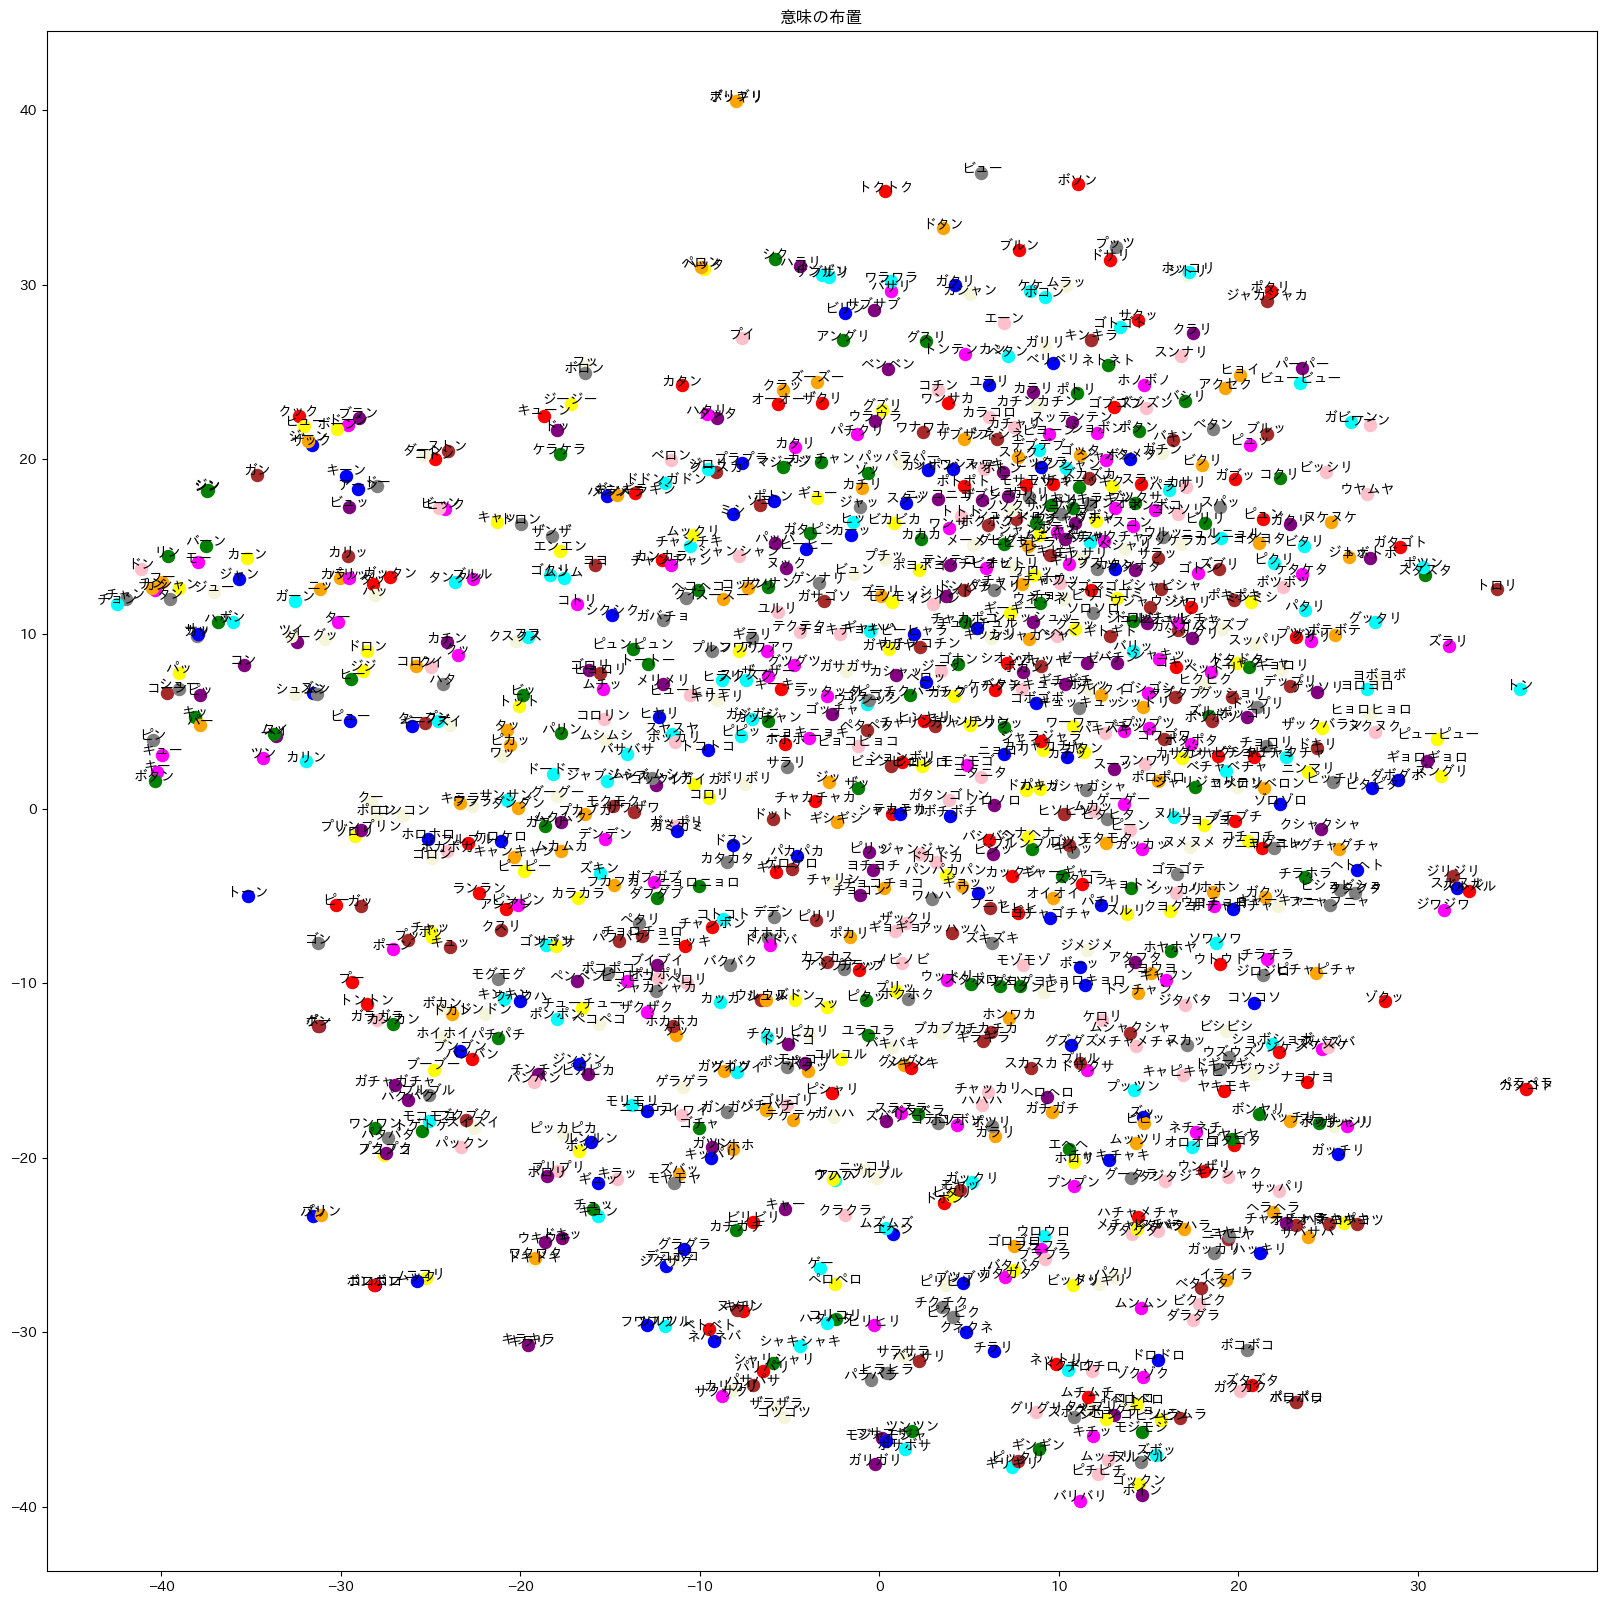

In [ ]:
plt.figure(figsize=(20, 20))
fontsize=10
size=300
for i, vec in enumerate(X0):

    c = colors[i % len(colors)]
    plt.scatter(vec[0], vec[1], marker='.', color=c, s=size)
    plt.annotate(words[i], (vec[0],vec[1]), ha='center', fontsize=fontsize)

plt.title('意味の布置')

# 2. 音韻と意味とを合わせたオノマトペ生成モデル

## 2.1 データセットの定義

In [31]:
class onomatope_phon_seme_Dataset(Dataset):
    def __init__(self,
                 phoneme:list=phoneme,
                 phon_vecs:np.ndarray=phone_emb_vec,
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_onomatope,
                 seme_vecs:np.array=w2v_onomatope.vectors)->None:
        self.ds_name = 'onomatope_phon_seme_dataset'
        self.w2v = w2v

        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + phoneme
        self.phon_vecs = phon_vecs
        self.seme_vecs = seme_vecs
        self.words = w2v.index_to_key
        wrd2phn = {}
        for wrd in self.words:
            phon = kunrei(wrd).split(' ')
            wrd2phn[wrd] = phon
        self.wrd2phn = wrd2phn

    def __len__(self):
        return len(self.words) # 936

    def __getitem__(self, idx:int)->list:
        phon_vec = torch.tensor(self.phon_vecs[idx]).to(device)
        seme_vec = torch.tensor(self.seme_vecs[idx]).to(device)
        inp = torch.cat((phon_vec, seme_vec)).to(device)

        wrd = self.words[idx]
        phons = self.wrd2phn[wrd]
        phon_ids = [self.phoneme.index(p) for p in phons]
        tch = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        tch = torch.LongTensor(tch).to(device)
        return inp, tch

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def getitem(self, idx:int):
        wrd = self.words[idx]
        phon = self.wrd2phn[wrd]
        phon_ids = [self.phoneme.index(p) for p in phon]
        phon_ids = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        return wrd, phon, phon_ids

    def target_ids2target(self, ids:list):
        return self.phon_ids2phon(ids)


onomatope_ps_ds = onomatope_phon_seme_Dataset()
onomatope_ps_ds.__len__()
inp, tch = onomatope_ps_ds.__getitem__(0)
print(inp.size(), n_hid)
print(tch, onomatope_ps_ds.phon_ids2phon(tch.detach().numpy()), onomatope_ps_ds.words[0])


torch.Size([232]) 32
tensor([ 1,  6, 22, 36, 33, 12, 22, 36,  2]) ['<SOW>', 'a', 'k', 'u', 's', 'e', 'k', 'u', '<EOW>'] アクセク


## 2.2 音韻と意味とを入力としてオノマトペを生成するモデルの定義

In [28]:
import copy

class Vec2Seq(nn.Module):
    def __init__(self,
                 inp_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 decoder:nn.Module=p2p_.decoder,
                 bidirectional:bool=False):
        super().__init__()

        self.decoder = copy.deepcopy(decoder)

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(
            in_features=inp_dim,
            out_features=n_hid)
        self.decoder_emb = nn.Embedding(
            num_embeddings=dec_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.decoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # 最終出力層
        self.bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(self.bi_fact * n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        hnx = hnx.unsqueeze(0)
        cnx = cnx.unsqueeze(0)

        if self.bi_fact == 2:
            hnx = hnx.repeat(2)
            cnx = cnx.repeat(2)

        dec_emb = self.decoder_emb(dec_inp)

        batch_size = enc_inp.size(0)
        exp_hid_size = self.decoder.get_expected_hidden_size(enc_inp, batch_sizes=[batch_size])
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        return self.out_layer(dec_out)

# 以下確認作業
ds = onomatope_ps_ds
ps2p = Vec2Seq(
    inp_dim=ds.w2v.vector_size+n_hid,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
print(ps2p.eval())

Vec2Seq(
  (decoder): LSTM(32, 32, batch_first=True)
  (enc_transform_layer): Linear(in_features=232, out_features=32, bias=True)
  (decoder_emb): Embedding(41, 32, padding_idx=0)
  (out_layer): Linear(in_features=32, out_features=41, bias=True)
)


In [29]:
#fit_seq2seq(epochs=1, model=ps2p, ds=onomatope_ps_ds)

ps2p.eval()
inp, tch = onomatope_ps_ds.__getitem__(0)
out = ps2p(inp, tch)
print(out.size())
out.detach().max(dim=1)

torch.Size([9, 41])


torch.return_types.max(
values=tensor([0.3604, 0.2833, 0.2288, 0.2168, 0.2555, 0.2764, 0.1904, 0.2064, 0.3145]),
indices=tensor([22, 32, 32, 32,  9,  6, 22,  5, 34]))

## 2.3 モデルの訓練

In [ ]:
res = fit_seq2seq(epochs=50, model=ps2p, ds=onomatope_ps_ds, interval=8)

epoch: 1 batch: 8 loss:0.04984
epoch: 2 batch: 8 loss:0.03255
epoch: 3 batch: 8 loss:0.02628
epoch: 4 batch: 8 loss:0.03935
epoch: 5 batch: 8 loss:0.02056
epoch: 6 batch: 8 loss:0.02633
epoch: 7 batch: 8 loss:0.02370
epoch: 8 batch: 8 loss:0.02080
epoch: 9 batch: 8 loss:0.01477
epoch:10 batch: 8 loss:0.01362
epoch:11 batch: 8 loss:0.01298
epoch:12 batch: 8 loss:0.00987
epoch:13 batch: 8 loss:0.01143
epoch:14 batch: 8 loss:0.00791
epoch:15 batch: 8 loss:0.00896
epoch:16 batch: 8 loss:0.01060
epoch:17 batch: 8 loss:0.01210
epoch:18 batch: 8 loss:0.00718
epoch:19 batch: 8 loss:0.00623
epoch:20 batch: 8 loss:0.00798


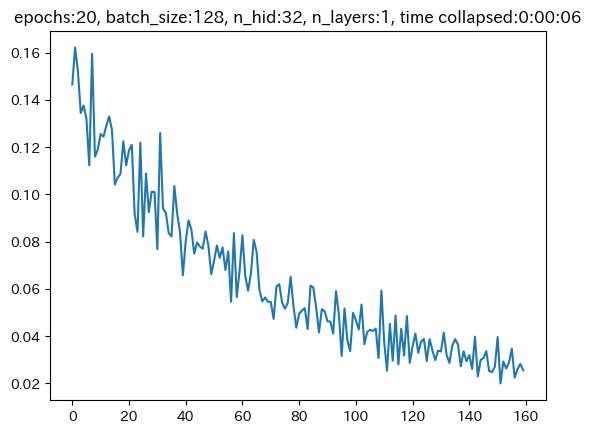

In [35]:
res = fit_seq2seq(epochs=20, model=ps2p, ds=onomatope_ps_ds, interval=8)

## 2.4 訓練結果の評価

In [36]:
eval_seq2seq(model=ps2p, ds=onomatope_ps_ds)

  0%|          | 0/936 [00:00<?, ?it/s]

{'エラー': [], '正解率': 100.0}

In [37]:
# 試みに表示させてみる
ps2p.eval()
Ns = np.random.permutation(onomatope_ps_ds.__len__())
for N in Ns[:20]:
    inp, tch = onomatope_ps_ds.__getitem__(N)
    out = ps2p(inp, tch)
    out_ = np.argmax(out.detach().numpy(), axis=1)
    print(f'{N:04d}',
          f'出力:{"".join([c for c in onomatope_ps_ds.phon_ids2phon(out_)[1:-1]]):15s}',
          f'正解:{onomatope_ps_ds.words[N]}')


0923 出力:waiwai          正解:ワイワイ
0401 出力:zuboQ           正解:ズボッ
0866 出力:musimusi        正解:ムシムシ
0185 出力:kuchakucha      正解:クチャクチャ
0867 出力:musyakusya      正解:ムシャクシャ
0931 出力:waNsaka         正解:ワンサカ
0419 出力:tajitaji        正解:タジタジ
0597 出力:pakapaka        正解:パカパカ
0036 出力:oioi            正解:オイオイ
0135 出力:kyuQ            正解:キュッ
0297 出力:zaQku           正解:ザック
0801 出力:horohoro        正解:ホロホロ
0206 出力:guQ             正解:グッ
0141 出力:kyorokyoro      正解:キョロキョロ
0833 出力:pokoN           正解:ポコン
0258 出力:gosigosi        正解:ゴシゴシ
0129 出力:kiQpari         正解:キッパリ
0296 出力:zaQ             正解:ザッ
0020 出力:uneune          正解:ウネウネ
0782 出力:pekopeko        正解:ペコペコ


In [38]:
seme_vec = torch.tensor(w2v['危険']).to(device)

ds = onomatope_ps_ds
onomatope_wrd = 'ミシミシ' # カタカナである必要がある
onomatope_idx = ds.words.index(onomatope_wrd)
#print(onomatope_idx)
phon_vec = torch.tensor(phone_emb[onomatope_idx]).to(device)
inp = torch.cat((phon_vec, seme_vec)).to(device)

phons = ds.wrd2phn[onomatope_wrd]
phon_ids = [ds.phoneme.index(p) for p in phons]
tch = [ds.phoneme.index('<SOW>')]+phon_ids+[ds.phoneme.index('<EOW>')]
tch = torch.LongTensor(tch).to(device)

ps2p.eval()
res = ps2p(inp, tch)

out_ = np.argmax(res.detach().numpy(), axis=1)
print(f'出力:{"".join([c for c in ds.phon_ids2phon(out_)[1:-1]]):15s}')

#phon_vec = torch.tensor(ps2p.phon_vecs[idx]).to(device)
#seme_vec = torch.tensor(self.seme_vecs[idx]).to(device)
#inp = torch.cat((phon_vec, seme_vec)).to(device)


出力:misimisi       
